<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# SimpleTransformers Text Classifier FineTuning

by Fabian Märki

## Summary
The aim of this notebook is to use [Simple Transformer](https://simpletransformers.ai) and fine tune a text classifier (using Transformer models has never been *simpler*). 

## Links
- https://simpletransformers.ai/docs/classification-specifics
- https://simpletransformers.ai/docs/classification-models
- https://simpletransformers.ai/docs/binary-classification


## Docker
In case you use docker make sure to increase shared memory size (e.g. by adding the flag *--shm-size 2gb*)

This notebook does not contain assigments: <font color='red'>Enjoy.</font>

<a href="https://colab.research.google.com/github/markif/2024_FS_CAS_NLP_LAB_Notebooks/blob/master/08_a_SimpleTransformers_Text_Classifier_FineTuning.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download

import numpy as np
import pandas as pd

import tensorflow as tf

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-48-generic
Python version: 3.6.9
CPU cores: 6
RAM: 31.12GB total and 25.45GB available
Tensorflow version: 2.5.1
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 7.54 s, sys: 1.42 s, total: 8.95 s
Wall time: 5.17 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
%%capture

!pip install simpletransformers

In [7]:
# Activate for faster training
#data = data.head(5000)

In [8]:
params = {
    "verbose": True,
    "batch_size": 32,
    #"X_column_name": "text_clean",
    "X_column_name": "text",
    "y_column_name": "label",
}

In [9]:
def create_simple_transformer_classification_model_and_set(params, data):

    from fhnw.nlp.utils.params import get_classification_type
    from fhnw.nlp.utils.system import get_gpu_device_number
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    transformer_model_type = params.get("transformer_model_type", "distilbert")
    transformer_model_name = params.get("transformer_model_name", "distilbert-base-multilingual-cased")
    transformer_dropout = params.get("transformer_dropout", 0.3)
    transformer_attention_dropout = params.get("transformer_attention_dropout", 0.3)
    y_column_name = params.get("y_column_name", "label")
    
    gpu_device_nr = get_gpu_device_number()
    classification_type = get_classification_type(params, data)
    
    if classification_type == "multi-label":
        from simpletransformers.classification import MultiLabelClassificationArgs
            
        model_args = MultiLabelClassificationArgs()
    else:
        from simpletransformers.classification import ClassificationArgs
            
        model_args = ClassificationArgs()

    #model_args.use_early_stopping = True
    #model_args.early_stopping_delta = 0.01
    #model_args.early_stopping_metric = "mcc"
    #model_args.early_stopping_metric_minimize = False
    #model_args.early_stopping_patience = 5

    #model_args.evaluate_during_training = True
    #model_args.evaluate_during_training_steps = 1000

    model_args.num_train_epochs = params.get("training_epochs", 3)
    model_args.learning_rate = params.get("learning_rate", 4e-5)
    model_args.train_batch_size=params.get("batch_size", 64)
    model_args.eval_batch_size=model_args.train_batch_size
    model_args.labels_list = list(data[y_column_name].unique())
    # these might change depending on the model (these are for distilbert)
    # without increasing dropout the model severely overfits 
    # see plots at the end which are from a run with default dropout
    model_args.config = {"dropout": transformer_dropout,
                         "attention_dropout": transformer_attention_dropout,
                         "seq_classif_dropout": transformer_dropout,
                        }


    if classification_type == "multi-label":
        from simpletransformers.classification import MultiLabelClassificationModel
            
        transformer_model = MultiLabelClassificationModel(transformer_model_type, 
                                    transformer_model_name, 
                                    use_cuda=gpu_device_nr != -1, 
                                    cuda_device=gpu_device_nr, 
                                    args=model_args)
    else:
        from simpletransformers.classification import ClassificationModel
            
        transformer_model = ClassificationModel(transformer_model_type, 
                                    transformer_model_name, 
                                    use_cuda=gpu_device_nr != -1, 
                                    cuda_device=gpu_device_nr, 
                                    args=model_args)
    
    params.setdefault(computed_objects_column_name, {})["simple_transformer_model"] = transformer_model

In [10]:
create_simple_transformer_classification_model_and_set(params, data)

Inferred classification type: binary


Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classif

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [11]:
from sklearn.model_selection import train_test_split

y_column_name = params.get("y_column_name", "label")

data_train, data_test = train_test_split(data, shuffle=True, random_state=42, stratify=data[y_column_name])
data_train, data_val = train_test_split(data_train, shuffle=True, random_state=42, stratify=data_train[y_column_name])

In [12]:
import logging

logging.basicConfig(level=logging.WARNING)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [13]:
X_column_name = params.get("X_column_name", "text")
y_column_name = params.get("y_column_name", "label")

data_train = data_train.drop(data_train.columns.difference([X_column_name, y_column_name]), axis=1)
data_test = data_test.drop(data_test.columns.difference([X_column_name, y_column_name]), axis=1)
data_val = data_val.drop(data_val.columns.difference([X_column_name, y_column_name]), axis=1)

data_train = data_train.rename(columns={y_column_name: "labels"}, errors='ignore')
data_test = data_test.rename(columns={y_column_name: "labels"}, errors='ignore')
data_val = data_val.rename(columns={y_column_name: "labels"}, errors='ignore')

params["y_column_name"] = "labels"

In [14]:
from shutil import rmtree

rmtree("outputs", ignore_errors=True)

In [15]:
%%time

computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
model = params[computed_objects_column_name]["simple_transformer_model"]

model.train_model(train_df=data_train, eval_df=data_val)

  0%|          | 0/186292 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/5822 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/5822 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/5822 [00:00<?, ?it/s]

CPU times: user 41min 56s, sys: 22.2 s, total: 42min 19s
Wall time: 42min 19s


(17466, 0.07704465487260533)

In [17]:
from fhnw.nlp.utils.ploting import report_classification_results

In [18]:
%%time

X_column_name = params.get("X_column_name", "text")
y_column_name = params.get("y_column_name", "labels")

y_pred = model.predict(data_train[X_column_name].to_list())[0]

  0%|          | 0/186292 [00:00<?, ?it/s]

  0%|          | 0/5822 [00:00<?, ?it/s]

Check performance on all data.

**Note:** This time the model was trained with the original data (no data augmentation) and on the *text* column (with cleaning but without text normalization).

Set Population: 186292
Accuracy: 0.9891


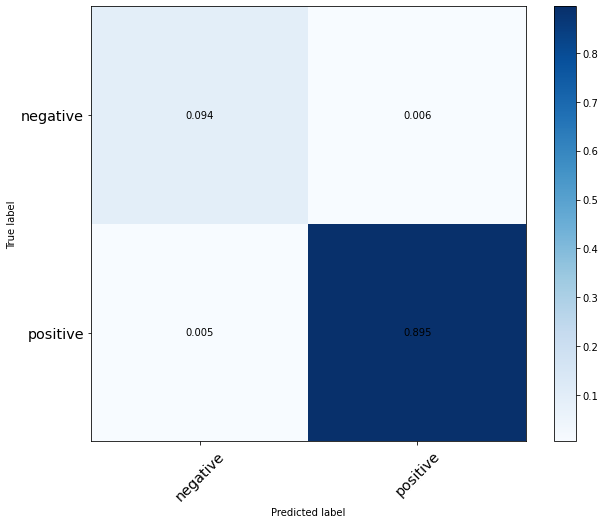

              precision    recall  f1-score   support

    negative       0.95      0.94      0.95     18574
    positive       0.99      0.99      0.99    167718

    accuracy                           0.99    186292
   macro avg       0.97      0.97      0.97    186292
weighted avg       0.99      0.99      0.99    186292



In [19]:
report_classification_results(params, data_train["labels"].to_list(), y_pred)

In [20]:
y_pred = model.predict(data_test[X_column_name].to_list())[0]

  0%|          | 0/82797 [00:00<?, ?it/s]

  0%|          | 0/2588 [00:00<?, ?it/s]

Set Population: 82797
Accuracy: 0.9789


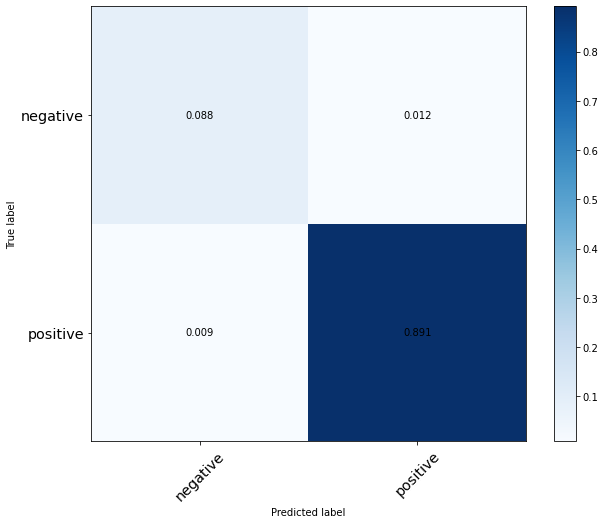

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      8256
    positive       0.99      0.99      0.99     74541

    accuracy                           0.98     82797
   macro avg       0.95      0.93      0.94     82797
weighted avg       0.98      0.98      0.98     82797



In [21]:
report_classification_results(params, data_test["labels"].to_list(), y_pred)

In [22]:
y_pred = model.predict(data_val[X_column_name].to_list())[0]

  0%|          | 0/62098 [00:00<?, ?it/s]

  0%|          | 0/1941 [00:00<?, ?it/s]

Set Population: 62098
Accuracy: 0.9784


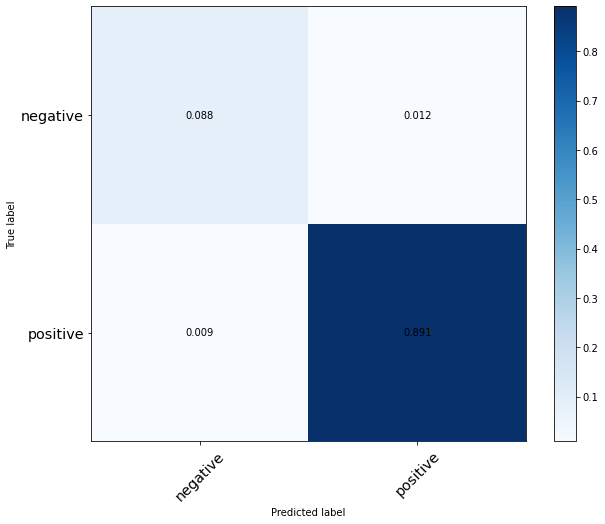

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      6192
    positive       0.99      0.99      0.99     55906

    accuracy                           0.98     62098
   macro avg       0.94      0.93      0.94     62098
weighted avg       0.98      0.98      0.98     62098



In [23]:
report_classification_results(params, data_val["labels"].to_list(), y_pred)